## RBM's in Pytorch

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.utils.data
from torch.utils.data import Dataset,DataLoader
import torch.nn as nn
import torch.nn.functional
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Set machine's temperature value
T = 4.0

In [3]:
# Define model
class RBM(nn.Module):
   def __init__(self,
               n_vis,
               n_hin,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return torch.nn.functional.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v):
        p_h = torch.sigmoid(torch.nn.functional.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = torch.sigmoid(torch.nn.functional.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = torch.nn.functional.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()

In [4]:
# Network hyperparamters
L = 6
N_spins = L**2
n_vis = N_spins
n_hin = N_spins

rbm = RBM(n_vis,n_hin,k=1)
# rbm.load_state_dict(torch.load('./L_10_T_0.25.pt'))
# rbm.eval()

In [6]:
import sys
sys.path.append('../')
import ising_analysis
import importlib
importlib.reload(ising_analysis)

<module 'ising_analysis' from '../ising_analysis.py'>

In [7]:
# Create random initial configuration
num_walks = 1
a = torch.empty(num_walks,L*L).uniform_(0, 1)
v_in = torch.bernoulli(a)
v_in

tensor([[1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0.,
         1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0.]])

In [23]:
%%time
files = []
filenames = []
for w in range(num_walks):
    # Open file for writing
    filename = "L_10_T_0.25_rbm_walk_"+str(w)+".dat"
    file = open(filename, "w")
    header = "#L=%d, T=%.2f \n# E     M \n"
    file.write(header)
    files.append(file)
    filenames.append(filename)

# Initialize quantities to measure
E = np.zeros(num_walks)
M = np.zeros(num_walks)

# Set simulation parameters
bins_wanted = 2000 # number of samples to generate
sweep = L**2 # size of one Monte Carlo sweep
bin_size = 1 # number of samples  to 
skip = 1 # sweeps performed between measurement

bins_written = 0 # counts how many bins have been written to disk
measurement_ctr = 0 # to track if we can write to disk
m = 0 # iteration counter
while(bins_written<bins_wanted):
    
    m +=1
    
    # Update input and generated visible vector
    v_in, v_gen = rbm(v_in.view(-1, N_spins))
    v_in = v_gen
    
    # Perform measurement
    if (m%(sweep*skip)==0 and m>5000):
        
        # Unflatten and replace 0's with -1's
        ising_lattice = v_gen.detach().numpy().reshape((num_walks,L,L))
        ising_lattice[ising_lattice==0] = -1
        
        for w in range(num_walks):
            E[w] += ising_analysis.get_energy(ising_lattice[w],L)
            M[w] += ising_analysis.get_magnetization(ising_lattice[w],L)
        
        measurement_ctr += 1
        
        if (measurement_ctr==bin_size):
            
            # Write to disk
            for w in range(num_walks):
                files[w].write('%.2f %.2f \n'%(E[w]/bin_size,M[w]/bin_size))
            
            bins_written += 1
        
            # Reset counters and accumulators
            measurement_ctr = 0
            E = np.zeros(num_walks)
            M = np.zeros(num_walks)

            if bins_written%1000==0:
                print("bins_written: ",bins_written)
            
# Close files           
for w in range(num_walks):
    files[w].close()

bins_written:  1000
bins_written:  2000
CPU times: user 12.2 s, sys: 563 ms, total: 12.7 s
Wall time: 12.8 s


In [24]:
# Load rbm_sampled data
num_throwaways = 500
rbm_E_all_walks = np.zeros((bins_wanted-num_throwaways,num_walks))
rbm_M_all_walks = np.zeros((bins_wanted-num_throwaways,num_walks))
for w,filename in enumerate(filenames):
    rbm_data = np.loadtxt(filename)[num_throwaways:]
    rbm_E_all_walks[:,w] = rbm_data[:,0]
    rbm_M_all_walks[:,w] = rbm_data[:,1]

# Compute seed-wise mean
rbm_E = np.mean(rbm_E_all_walks,axis=1)
rbm_M = np.mean(rbm_M_all_walks,axis=1)

# Compute quantities above but per spins
rbm_e = rbm_E/L**2
rbm_m = rbm_M/L**2

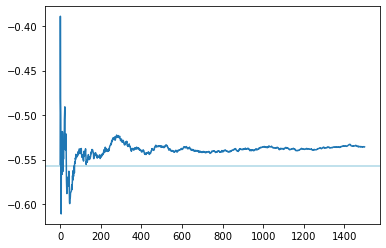

In [25]:
# Plot running average of energy per spin
# plt.plot(np.arange(rbm_e.shape[0]),np.cumsum(rbm_e)/np.arange(1,rbm_e.shape[0]+1))
for w in range(num_walks):
    plt.plot(np.arange(rbm_E_all_walks[:,w].shape[0]),np.cumsum(rbm_E_all_walks[:,w])/L**2/np.arange(1,rbm_E.shape[0]+1))
plt.axhline(ising_analysis.e_exact_func(T),zorder=-1,color='lightblue')
plt.savefig('e_without_abs.pdf',dpi=300)

../ising_analysis.py:103: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(1-np.tanh(K)**2)**4/(16*np.tanh(K)**4))**(1/8)


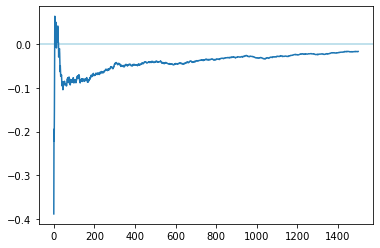

In [26]:
# Plot running average of energy per spin
# plt.plot(np.arange(rbm_e.shape[0]),np.cumsum(rbm_e)/np.arange(1,rbm_e.shape[0]+1))
for w in range(num_walks):
    plt.plot(np.arange(rbm_M_all_walks[:,w].shape[0]),np.cumsum(rbm_M_all_walks[:,w])/L**2/np.arange(1,rbm_M.shape[0]+1))
plt.axhline(np.nan_to_num(ising_analysis.m_exact_func(T)),zorder=-1,color='lightblue')
plt.savefig('m_without_abs.pdf',dpi=300)

# Train model

## Create Ising Dataset object from Monte Carlo data

In [8]:
class CustomIsingDataset(Dataset):
    def __init__(self,spins):
        self.spins = spins
        
    def __len__(self):
        return len(self.spins)
    
    def __getitem__(self,idx):
        spins = self.spins[idx]
        sample = {'spins': spins}
        return sample

In [14]:
filename = '../uncorrelated_monte_carlo_data/L_6_T_4.0_spins_seed_0.dat'

# Load data from file
spins = np.loadtxt(filename,dtype=np.float32) # network training sometimes breaks for 'double'

# Convert -1's to 0's for RBM compatibility
spins[spins==-1] = 0

# Convert to Python list for dataframe promotion simplicity
spins = list(spins)

# Convert spin data to pandas dataframe
spins_df = pd.DataFrame({'spins':spins})

# Create Dataset object
spins_dataset = CustomIsingDataset(spins_df['spins'])

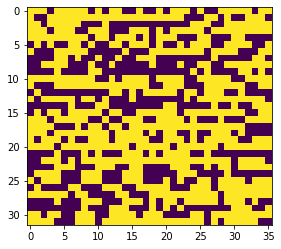

In [15]:
# Show first few rows of loaded Monte Carlo configurations
plt.imshow(spins[0:32])

In [16]:
# Iterate over dataset to check if it looks good.
DL_DS = DataLoader(spins_dataset, batch_size=2, shuffle=True)
for (idx, batch) in enumerate(DL_DS):
    if idx == 3: break # so we don't print too much :)
    # Print the 'text' data of the batch
    print(idx, 'Spins data: ', batch['spins'],'\n')

0 Spins data:  tensor([[1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
         1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1.,
         1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]) 

1 Spins data:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
         0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.]]) 

2 Spins data:  tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1.,
         0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 

Looks good!

## Perform train/test split of full dataset

In [17]:
N_full = len(spins_dataset) # total length of full dataset
N_train = int(N_full*1.0)
N_test = N_full - N_train

print("Full set: ", N_full,'\n')
print("Train set: ", N_train)
print("Test set: ", N_test,'\n')

# To use random_split(), lengths of train/test sets must add up to full. Check.
if (N_train + N_test == N_full): print('Good! Length of splitted sets adds up to full length.') 

Full set:  16000 

Train set:  16000
Test set:  0 

Good! Length of splitted sets adds up to full length.


In [18]:
# Perform random non-overlapping train/test split
train_spins,test_spins = torch.utils.data.random_split(spins_dataset,[N_train,N_test])

## Define the model

In [19]:
# Extract temperature and linear size from file name
T = float(filename.split('_')[-2])
L = int(filename.split('_')[-4])

print("T = %0.2f"%T)
print("L = %d"%L)

ValueError: could not convert string to float: 'seed'

## Initialize and train the model

In [21]:
%%time
# Network hyperparamters
N_spins = L**2
n_vis = N_spins
n_hin = N_spins

# Training parameters
epochs = 2000
η = 0.01
batch_size = 32

# Define train and test DataLoaders
train_loader = DataLoader(train_spins, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_spins, batch_size=batch_size, shuffle=True)

rbm = RBM(n_vis,n_hin,k=1)
train_op = optim.SGD(rbm.parameters(),η)

loss_at_epoch = []
mean_loss = 1
epoch = 0
# while abs(mean_loss) > 0.01:
for epoch in range(epochs):
    loss_ = []
    for idx, data in enumerate(train_loader):
        
        data = data['spins']
        data = Variable(data.view(-1,N_spins))
        sample_data = data.bernoulli() # will serve as initial input
        
        v,v1 = rbm(sample_data) # v: input, v1: generated
#         loss = torch.abs(rbm.free_energy(v) - rbm.free_energy(v1))
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
    
    mean_loss = np.mean(loss_)
    loss_at_epoch.append(np.mean(loss_))
    if epoch%10 == 0:
        print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))
    epoch += 1
print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))

Training loss for 0 epoch: 0.024938274174928665
Training loss for 10 epoch: -0.42430517077445984
Training loss for 20 epoch: -0.7459670305252075
Training loss for 30 epoch: -0.2829679548740387
Training loss for 40 epoch: -0.26736316084861755
Training loss for 50 epoch: -0.3564505875110626
Training loss for 60 epoch: -0.24690961837768555
Training loss for 70 epoch: -0.16597619652748108
Training loss for 80 epoch: -0.14300625026226044
Training loss for 90 epoch: -0.16701936721801758
Training loss for 100 epoch: -0.1743997484445572
Training loss for 110 epoch: -0.1604616492986679
Training loss for 120 epoch: -0.11566369980573654
Training loss for 130 epoch: -0.10160873085260391
Training loss for 140 epoch: -0.11574533581733704
Training loss for 150 epoch: -0.10824574530124664
Training loss for 160 epoch: -0.13195061683654785
Training loss for 170 epoch: -0.15855969488620758
Training loss for 180 epoch: -0.18260324001312256
Training loss for 190 epoch: -0.18949414789676666
Training loss fo

KeyboardInterrupt: 

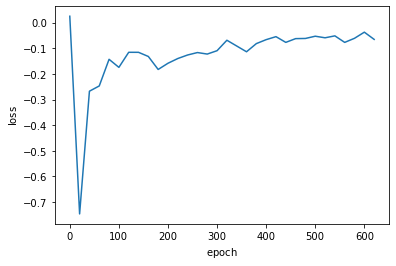

In [22]:
# Plot loss function
loss_at_epoch = np.array(loss_at_epoch)
plt.plot(range(len(loss_at_epoch))[::20],loss_at_epoch[::20])
# plt.yscale('log')
plt.xlabel(r'$\rm epoch$')
plt.ylabel(r'$\rm loss$');
plt.savefig('L_10_T_0.25_loss.pdf',dpi=300)

The network is now trained (seemingly).

### Save the model

In [21]:
torch.save(rbm.state_dict(),'./L_10_T_0.25.pt')

## Sampling Ising configurations from model

With our trained model, we now want to sample a new set of Ising configuraions according to the model probability distribution.

In [22]:
configs = next(iter(train_loader))['spins'] # grabs a batch of spins from training set
configs.shape

torch.Size([32, 100])

In [23]:
v_in, v_gen = rbm(configs.view(-1, N_spins))
v_in

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 1., 0.,  ..., 0., 0., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 1.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 1., 1., 1.]])

### Input

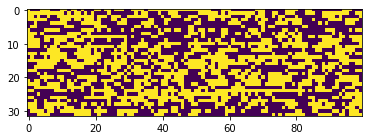

In [24]:
plt.imshow(v_in);

### Generated

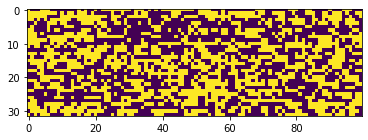

In [25]:
plt.imshow(v_gen.detach().numpy());

### Sampling a longer Markov chain

The above results are for a Markov chain of length 1. As such, these will be very correlated in general. The idea is to start out with a random input and run a longer Markov chain. To test if the RBM samples the correct configurations, I will start out with a ferromagnet configuration (i.e, all spins pointing the same way), and hope that eventually the RBM returns disordered phase configurations instead.

### Create ferromagnetic configuration

In [26]:
v_in = next(iter(train_loader))['spins'] # grabs a batch of spins from training set
v_in[v_in==0] = 1
v_in
for i,sample in enumerate(v_in):
    if i%2 == 0:
        v_in[i] = 0
v_in

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

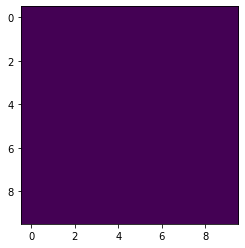

In [27]:
# Plot one Ising configuration
plt.imshow(v_in[0].reshape((L,L)))

### Plot random walk

In [ ]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

# Create ferromagnetic configuration
v_in = next(iter(train_loader))['spins'] # grabs a batch of spins from training set
v_in[v_in==0] = 1
v_in = v_in[0]
# for i,sample in enumerate(v_in):
#     if i%2 == 0:
#         v_in[i] = 0
        
# Plot initial visible vector
fig,ax = plt.subplots(figsize=(8,4.5), dpi=100, constrained_layout=True)
ax.imshow(v_in.detach().numpy().reshape(L,L))
display.clear_output(wait=True)
display.display(pl.gcf())
time.sleep(1.0)

num_gen = 20 # number of samples to generate
for i in range(num_gen):
    
    # Update input and generated visible vector
    v_in, v_gen = rbm(v_in.view(-1, N_spins))
    v_in = v_gen
        
    # Plot reconstructions of visible vector
    if i%1==0:
        
        ax.imshow(v_gen.detach().numpy().reshape(L,L))
        display.clear_output(wait=True)
        display.display(pl.gcf())
        time.sleep(0.5)

plt.clf();

The random walk took us from a ferromagnetic configuration to a disordered one! This is good.

# Load machine

RBM()

# Compute energy and magnetization

<module 'ising_analysis' from '../../../ising_analysis.py'>

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        [0., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 1.]])

bins_written:  1000


In [9]:
bins_written

2000

In [10]:
!wc -l 'L_10_T_0.25_rbm_walk_0.dat'

    2002 L_10_T_3.75_rbm_walk_0.dat


In [11]:
filenames

['L_10_T_3.75_rbm_walk_0.dat',
 'L_10_T_3.75_rbm_walk_1.dat',
 'L_10_T_3.75_rbm_walk_2.dat',
 'L_10_T_3.75_rbm_walk_3.dat',
 'L_10_T_3.75_rbm_walk_4.dat',
 'L_10_T_3.75_rbm_walk_5.dat',
 'L_10_T_3.75_rbm_walk_6.dat',
 'L_10_T_3.75_rbm_walk_7.dat',
 'L_10_T_3.75_rbm_walk_8.dat',
 'L_10_T_3.75_rbm_walk_9.dat',
 'L_10_T_3.75_rbm_walk_10.dat',
 'L_10_T_3.75_rbm_walk_11.dat',
 'L_10_T_3.75_rbm_walk_12.dat',
 'L_10_T_3.75_rbm_walk_13.dat',
 'L_10_T_3.75_rbm_walk_14.dat',
 'L_10_T_3.75_rbm_walk_15.dat',
 'L_10_T_3.75_rbm_walk_16.dat',
 'L_10_T_3.75_rbm_walk_17.dat',
 'L_10_T_3.75_rbm_walk_18.dat',
 'L_10_T_3.75_rbm_walk_19.dat']

In [20]:
rbm_E_all_walks

array([[-76., -48., -24., ..., -44., -36., -32.],
       [-36., -76., -84., ..., -40., -92., -40.],
       [-64., -44., -60., ..., -40., -64., -56.],
       ...,
       [-76., -68., -72., ..., -60., -56., -52.],
       [-72., -56., -64., ..., -48., -72., -56.],
       [-44., -44., -48., ..., -68., -52., -72.]])

In [16]:
np.mean(rbm_E/L**2)
T = 0.25

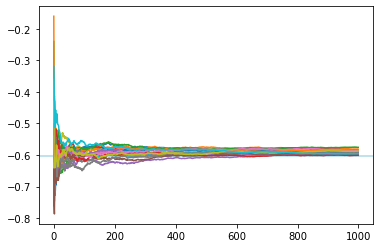

In [ ]:
# Plot running average of magnetization per spin
plt.plot(np.arange(rbm_m.shape[0]),np.cumsum(rbm_m)/np.arange(1,rbm_m.shape[0]+1),color='tab:orange')
plt.axhline(0,color='orange',zorder=-1)

# References

https://towardsdatascience.com/how-to-use-datasets-and-dataloader-in-pytorch-for-custom-text-data-270eed7f7c00

https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/

https://stats.stackexchange.com/questions/114844/how-to-compute-the-free-energy-of-a-rbm-given-its-energy

https://github.com/lisa-lab/DeepLearningTutorials/blob/master/code/rbm.py#L127